# 默认配置

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from waveforms import *
from scipy.signal import savgol_filter,correlate
# from scipy.signal import find_peaks
# from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import integrate

from pathlib import Path
import os
import time as TM

from quantum_driver.NS_MCI import Driver
DeviceIP = "192.168.1.194"



In [8]:
def Pulse_wav(waveform = 'cos',envelope = 'cosPulse',samplerate = 2e9,freq = 201e6,time_len = 30e-9,width = 15e-9,repeat = 1,delay =0):
    
    time = np.linspace(0,time_len,int(time_len*samplerate))
    pulse = (eval(f'{waveform}')(2*np.pi*freq))*(eval(f'{envelope}')(width)>>time_len/2)

    wav = zero()
    for i in range(repeat):
        wav += pulse >> (width + delay)*i
    wav >>= 2e-9
    
    return time,wav


def filepath_generate():
    basepath = Path(os.getcwd())/'data'/f'{TM.localtime()[0]}'/(f'{TM.localtime()[1]}'+f'{TM.localtime()[2]}')
    if basepath.exists() is False:
        os.makedirs(basepath)
    return basepath

#  仪器测试

In [171]:
import time
import pyvisa as visa
import numpy as np

DPOAddress = "TCPIP::192.168.1.63"
rm = visa.ResourceManager()
dpo = rm.open_resource(DPOAddress)

def DSO90254A_readDOPChannel(dpo,
                   channel,
                   period=None,
                   returnTime=False,  #是否返回时间
                   sampleRate=20e9):
    # dpo.query(":STOP; *OPC?")
    # dpo.query(":ADER?")
    # dpo.write(":SINGle")
    dpo.write(f":WAVeform:SOURce CHAN{channel}")
    data = dpo.query(":WAVeform:DATA?")
    data = np.array([float(s) for s in data.split(',')[:-1]])
    if period is not None:
        periodPointNum = int(period * sampleRate)
        n = len(data) // periodPointNum
        data = data[:n * periodPointNum].reshape(n,
                                                 periodPointNum).mean(axis=0)
    if returnTime:
        return np.arange(len(data)) / sampleRate, data
    else:
        return data
    
readDOPChannel = DSO90254A_readDOPChannel  

print(dpo.query('*Idn?'))

Agilent Technologies,DSO90254A,MY51050119,03.21.0001



# DAC

## 波形生成

In [57]:
DArate = 6e9
ADrate = 4e9

time_len = 100e-6
width = 4000e-9
freq = 7100e6

shots = 10000


ADPointNumber = round(time_len*ADrate) 
DAPointNumber = round(time_len*DArate)
round(time_len*DArate)

600000

24000


<IPython.core.display.Javascript object>


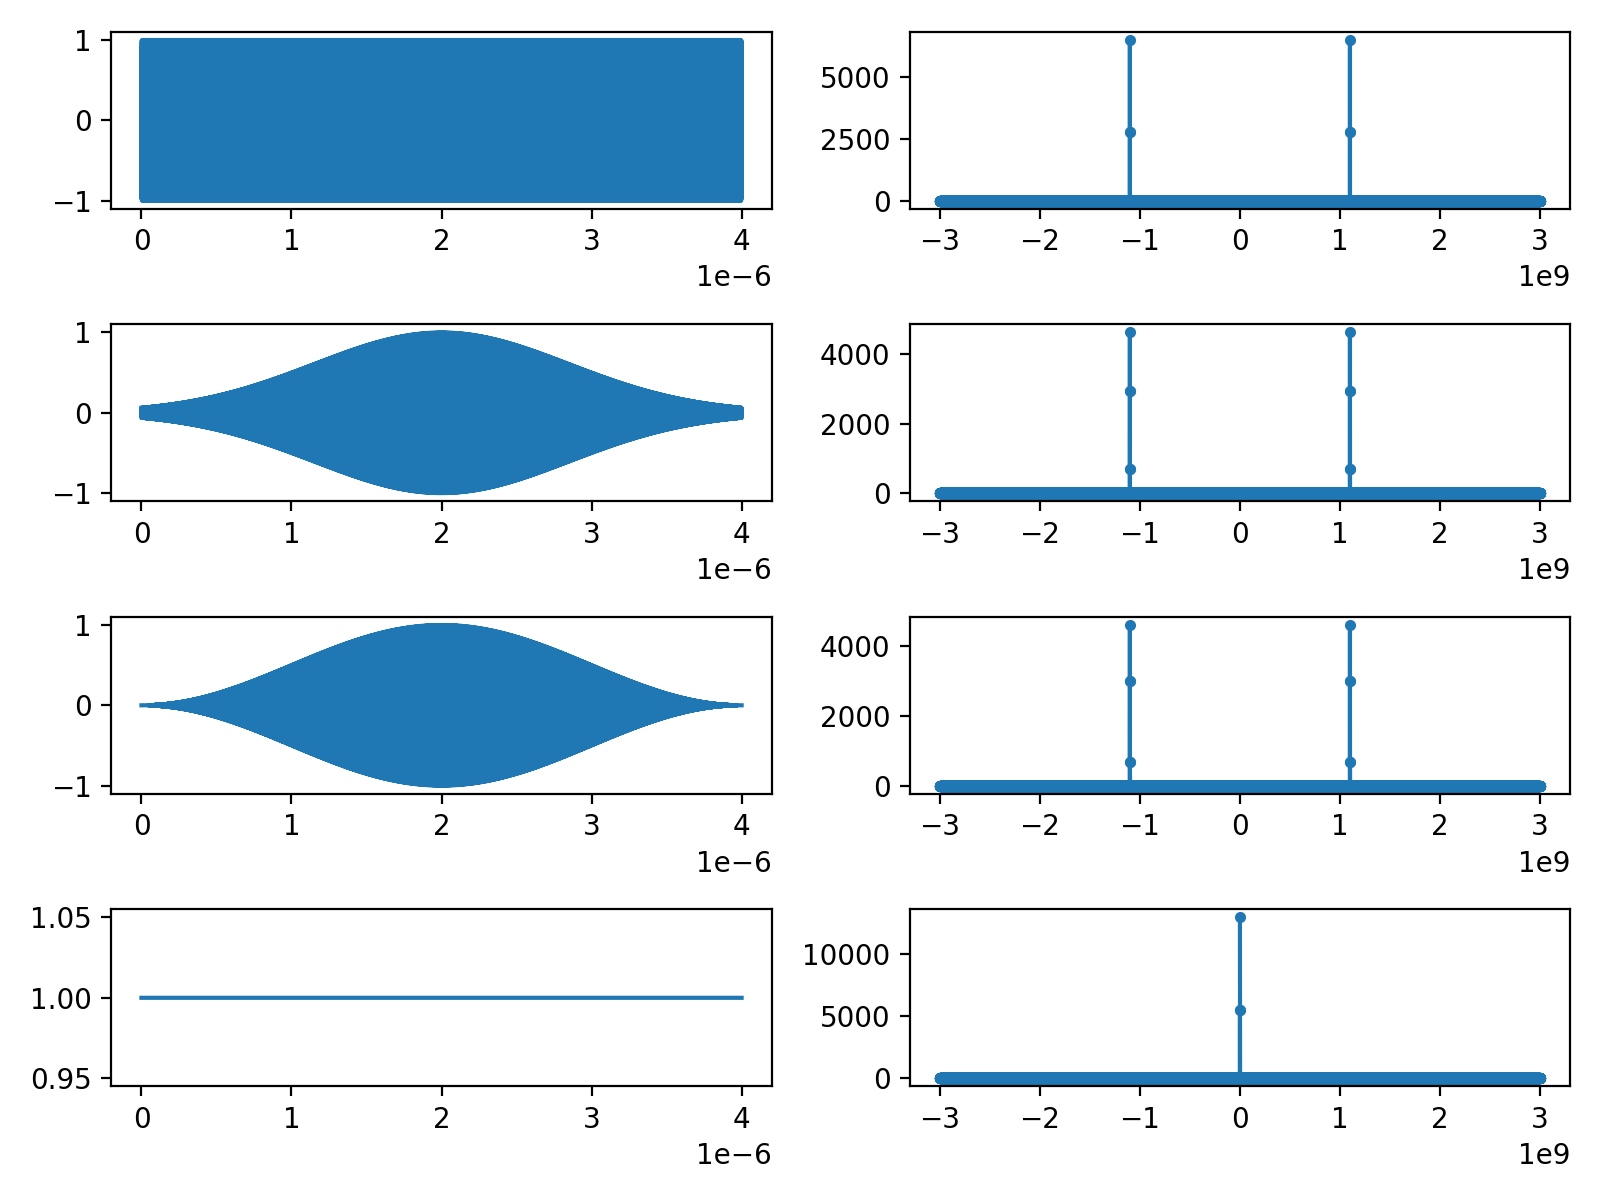

In [52]:

time = np.linspace(0,(DAPointNumber-1)/DArate, int(DAPointNumber))

wav1 = (cos(2*np.pi*freq))*(square(width,edge=2e-9)>>time_len/2)
wav2 = (cos(2*np.pi*freq))*(gaussian(width)>>time_len/2)
wav3 = (cos(2*np.pi*freq))*(cosPulse(width)>>time_len/2)

wav4 = (square(width)>>time_len/2)


print(len(wav1(time)))

fig,axs = plt.subplots(4,2,figsize=(8, 6))
# axs = axs.flatten()
for i in range(4):
    axs[i][0].plot(time,eval(f'wav{i+1}(time)'))
    fft_freq = np.fft.fftfreq(DAPointNumber,1/DArate)
    axs[i][1].plot(fft_freq,np.abs(np.fft.fft(np.hamming(DAPointNumber)*(eval(f'wav{i+1}(time)')))),'.-')
fig.tight_layout()

## 设备配置

### 实数波形

In [53]:
driver = Driver(DeviceIP)


sysparam = {
    'MixMode': 1, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0
}

driver.open(system_parameter=sysparam)
driver.set('Shot', 1024000)


指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功
Shot 配置成功


In [58]:
start = TM.time()

for i in range(8):
    driver.set('GenWave', wav3, i)  # 下发波形
print(TM.time()- start)


远程函数报错: 
<class 'NS_MCI.config.RPCMethodExecuteError'>:Traceback with variables (most recent call last):
  File "/home/digilab/RFSdemo/NS_MCI/config.py", line 116, in wrap
    return func(*args, **kwargs)
      args = (<__main__.RFSKitRPCServer object at 0x7f7c419300>, 'GenWave', ['waveform.Waveforms', b'\x80\x04\x95\xfa\x00\x00\x00\x00\x00\x00\x00\x8c\x12waveforms.waveform\x94\x8c\x08Waveform\x94\x93\x94)\x81\x94N}\x94(\x8c\x06bounds\x94G\x00\x00\x00\x00\x00\x00\x00\x00G>\xd0\xc6\xf7\xa0\xb5\xed\x8dG\x7f\xf0\x00\x00\x00\x00\x00\x00\x87\x94\x8c\x03seq\x94))\x86\x94K\x04GA7\xf7\xecS\xa8\xd4\x92G>\xc0\xc6\xf7\xa0\xb5\xed\x8d\x87\x94K\x04GB$\xc5\xff\xf3\x01\xf3;G\x00\x00\x00\x00\x00\x00\x00\x00\x87\x94\x86\x94K\x01K\x01\x86\x94\x86\x94h\n\x85\x94K\x01\x85\x94\x86\x94\x86\x94G?\xe0\x00\x00\x00\x00\x00\x00G?\xe0\x00\x00\x00\x00\x00\x00\x86\x94\x86\x94))\x86\x94\x87\x94\x8c\x03max\x94G\x7f\xf0\x00\x00\x00\x00\x00\x00\x8c\x03min\x94G\xff\xf0\x00\x00\x00\x00\x00\x00\x8c\x05start\x94N\x8c\x04st

In [151]:
driver.set('Waveform', wav3(time), 8)  # 下发波形
driver.set('Waveform', wav4(time), 7)

driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),6)
driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),5)

driver.set('GenWave', wav3, 6)    # 波形函数生成
driver.set('GenWave', wav3, 5)



driver.set('Shot', shots)
driver.set('GenerateTrig',  1e7)


Waveform 配置成功
Waveform 配置成功
LinSpace 配置成功
LinSpace 配置成功
GenWave 配置成功
GenWave 配置成功
Shot 配置成功
GenerateTrig 配置成功


<IPython.core.display.Javascript object>


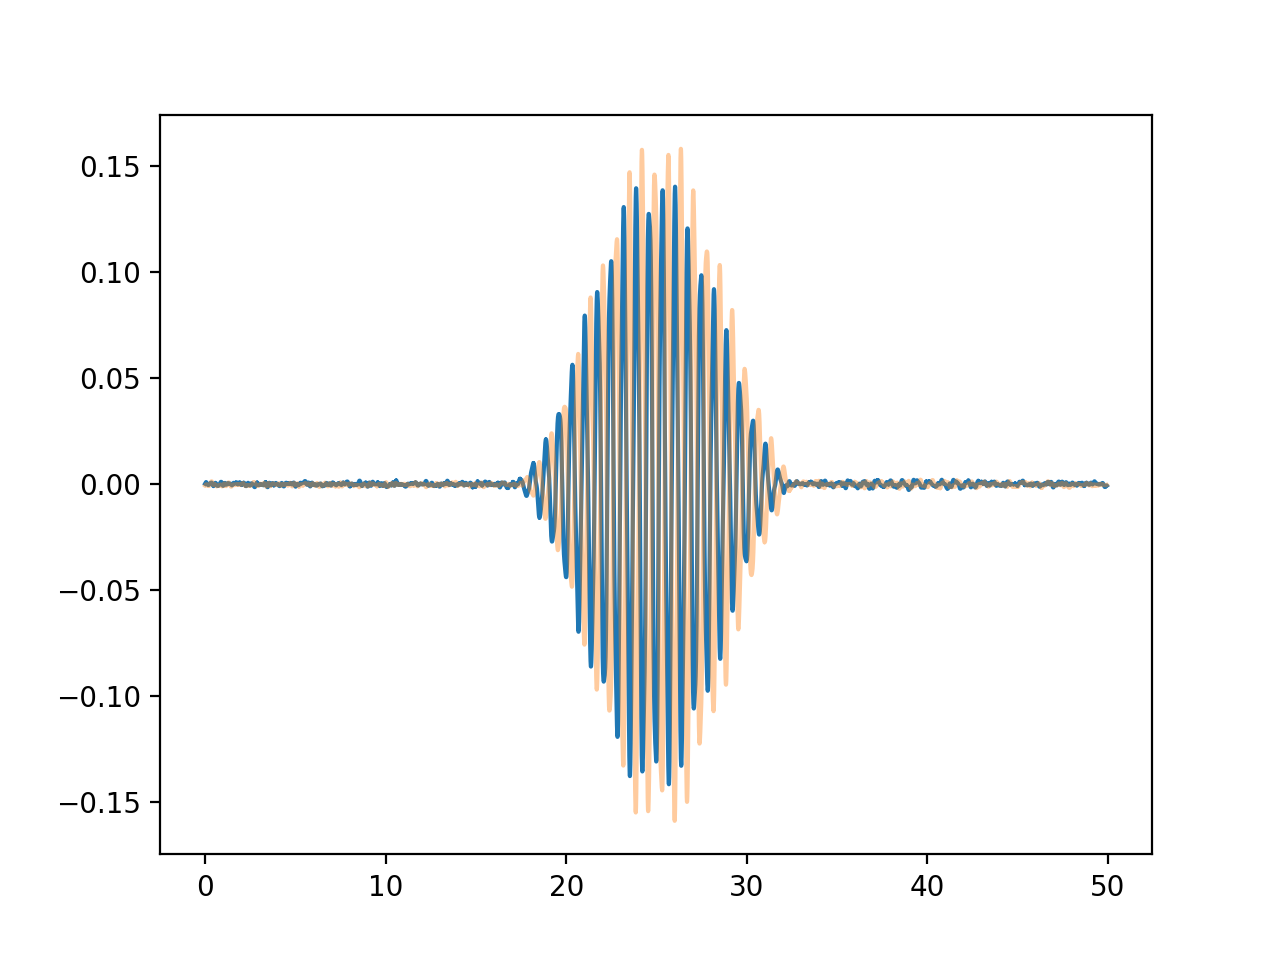

In [151]:
%matplotlib notebook

yc1 = []
yc3 = []

for i in range(5):
    t, y1 = readDOPChannel(dpo, 1,returnTime=True, sampleRate=320e9)
    t, y3 = readDOPChannel(dpo, 3,returnTime=True, sampleRate=320e9)

    yc1.append(y1)
    yc3.append(y3)


yr1 =  np.mean(yc1,axis=0)
yr3 =  np.mean(yc3,axis=0)

yr1.shape
plt.figure()
plt.plot(t/1E-9, yr1)
plt.plot(t/1E-9, yr3, alpha=0.4)

### 复数波形

<IPython.core.display.Javascript object>


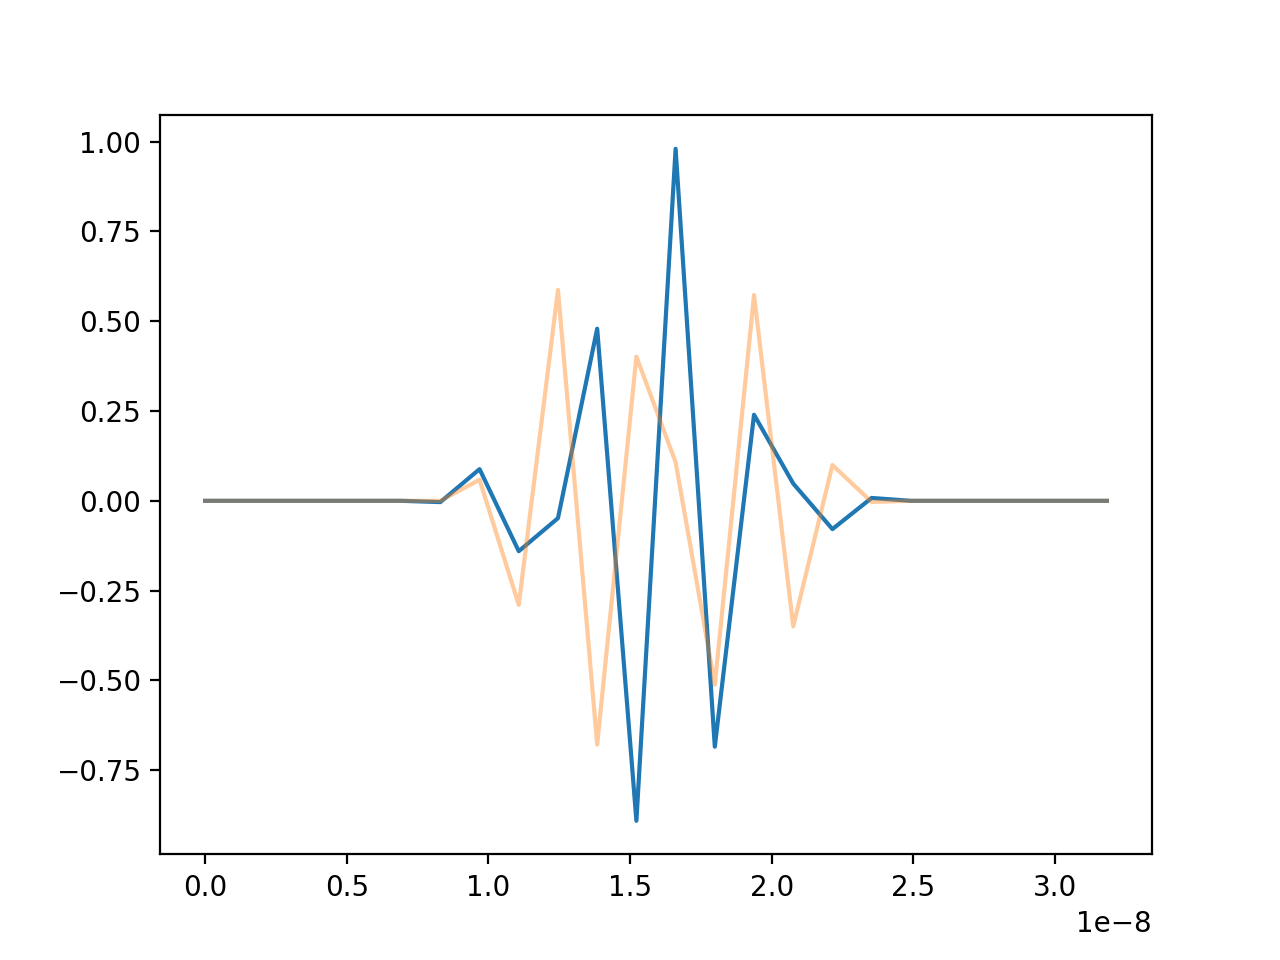

In [144]:
%matplotlib notebook


NCOfreq = 1.1e9
Ratio = 8


pulse = cosPulse(width)


x_wav = zero()
y_wav = zero()

I, Q = mixing(pulse>>time_len/2,freq=freq-NCOfreq)
x_wav += I
y_wav += Q

dout = x_wav*cos(2*np.pi*NCOfreq) + y_wav*sin(2*np.pi*NCOfreq)

"""
I, Q = mixing(pulse1 >> 50e-9, freq=freq, phase=np.pi/2)
x_wav += I
y_wav += Q


I, Q = mixing((0.5 * pulse) >> 2e-6, freq=freq, DRAGScaling=0.2)
x_wav += I
y_wav += Q
"""

tm = np.linspace(0,(DAPointNumber-1)/DArate, DAPointNumber)
tmratio = np.linspace(0,(DAPointNumber-1)/DArate, DAPointNumber//Ratio)


plt.plot(tmratio, x_wav(tmratio))
plt.plot(tmratio, y_wav(tmratio),alpha = 0.4)

#plt.plot(tm, dout(tm))
#plt.plot(tm, wav3(tm),alpha = 0.4)
plt.show()

In [145]:
driver = Driver(DeviceIP)

sysparam = {
    'MixMode': 1, 'RefClock': 'in', 'DAC抽取倍数': Ratio, 'DAC本振频率': NCOfreq/1e6
}

driver.open(system_parameter=sysparam)


指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [106]:
tmratio.shape

(24,)

In [118]:
driver.set('Waveform', wav3(time), 8)  # 下发波形
driver.set('Waveform', wav4(time), 7)

driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,int(DAPointNumber//Ratio)),5)

driver.set('GenWaveIQ', (y_wav, x_wav), 5)



driver.set('Shot', shots)
driver.set('GenerateTrig',  1e7)

Waveform 配置成功
Waveform 配置成功
LinSpace 配置成功
GenWaveIQ 配置成功
Shot 配置成功
GenerateTrig 配置成功


### DPO获取分析

<IPython.core.display.Javascript object>


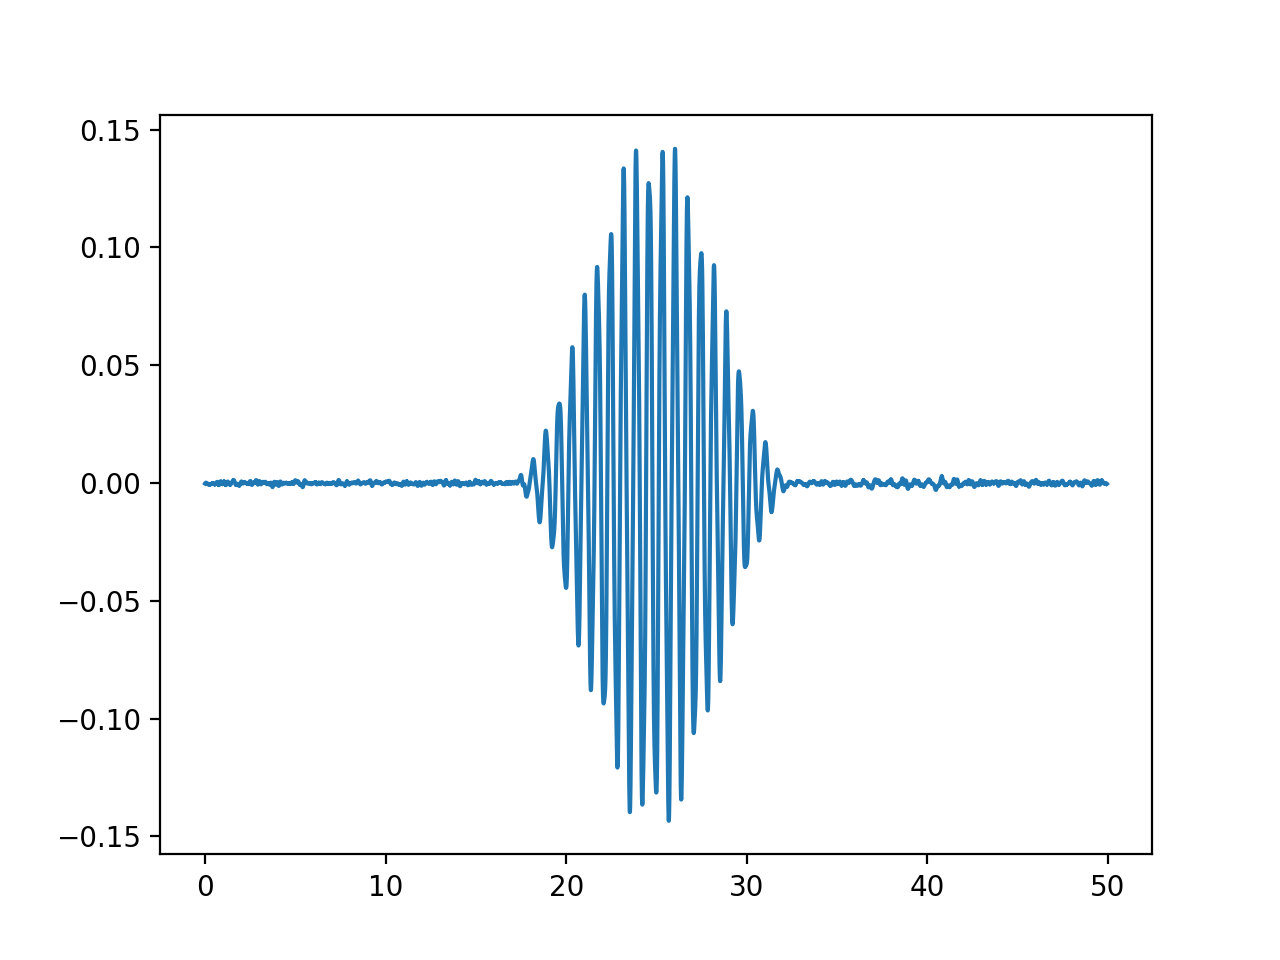

In [152]:
yc = []
for i in range(5):
    t, y1 = readDOPChannel(dpo, 1, returnTime=True, sampleRate=320e9)
    yc.append(y1)

yc =  np.mean(yc,axis=0)
yc.shape
plt.figure()
plt.plot(t/1E-9, yc)

In [153]:
time,wav = Pulse_wav(samplerate = 6e9,freq = 1400e6, time_len = 16e-9,width = 16e-9,repeat = 1)
wav = (wav+1)/2

<IPython.core.display.Javascript object>


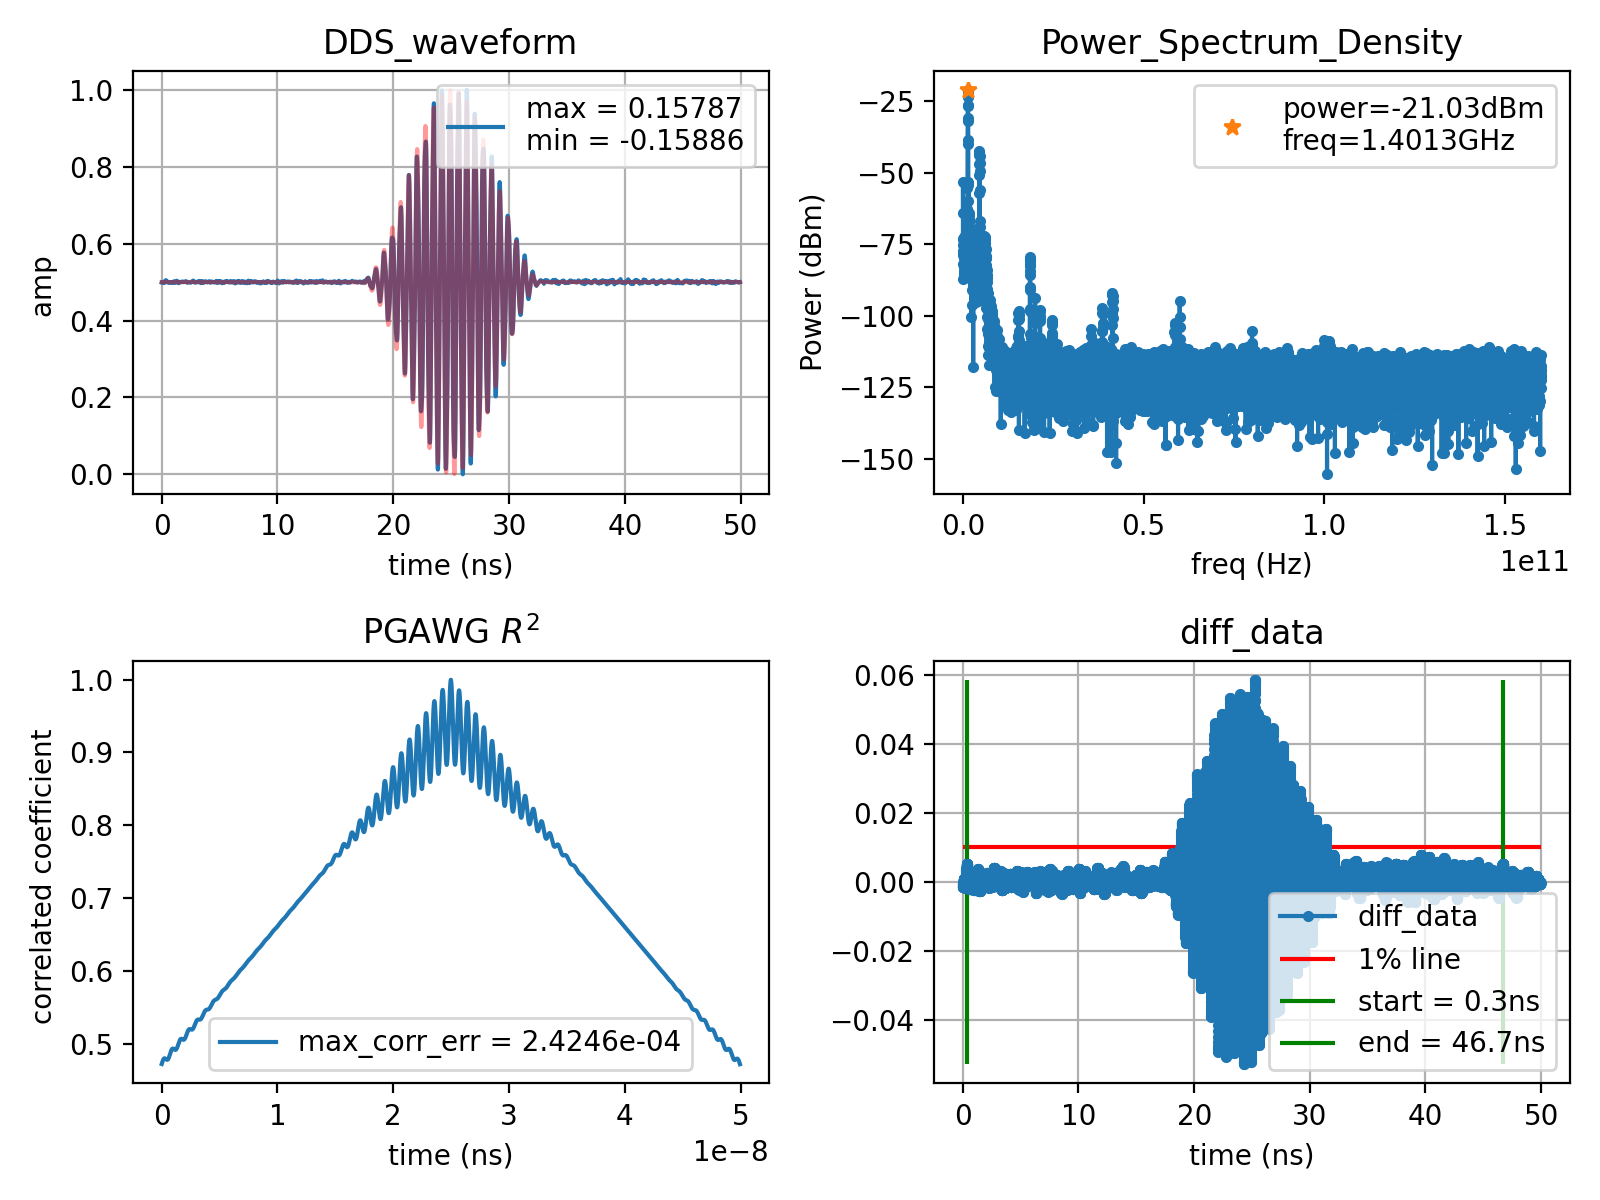

In [155]:
%matplotlib notebook
y = yr3
plt.figure(figsize=(8, 6))
plt.subplot(221)
ch = 8
maxValue = np.max(y)
minValue = np.min(y)
normlized_y = (y - minValue) / (maxValue - minValue)

plt.plot(t / 1e-9,
         normlized_y,
         label=f'max = {maxValue:.5f}\nmin = {minValue:.5f}')
plt.title('DDS_waveform')
plt.xlabel('time (ns)')
plt.ylabel('amp ')
plt.legend(loc=1)
plt.grid(visible=True, which='both', axis='both')

# plt.plot(t / 1e-9,wav(t),'-g',alpha = 0.4,label='origin')
temp = correlate(wav(t),normlized_y,mode='same',method='fft')
temp1 = [np.correlate((wav>>temp_t)(t),normlized_y) for temp_t in t]
align_t2 = t[np.argmax(temp1)]

# func = interp1d(np.arange(len(t)),temp,kind='cubic')
# smooth_t = np.linspace(0,len(t)-1,20001)
# smooth_y = savgol_filter(func(smooth_t),window_length=41, polyorder=3)

# align_t = t[int(smooth_t[np.argmax(smooth_y)])]-2*9.5e-9
# print(0.5*(t[0]+t[-1]))

new_wav = wav >> align_t2
#new_wav = wav >> 16e-9
plt.plot(t / 1e-9,new_wav(t),'-r',alpha = 0.4,label='align')
plt.show()
# plt.legend()

data_corr = correlate(new_wav(t),normlized_y,mode='same',method='fft')
data_corr /= np.sqrt(
    np.correlate(normlized_y, normlized_y)[0] *
    np.correlate(new_wav(t), new_wav(t))[0])
max_corr = np.max(data_corr)

plt.subplot(222)
f = interp1d(t,y**2/50,kind='linear')
value,_ = integrate.quad(f,t[0],t[-1])
freq = np.fft.fftfreq(len(t),t[1]-t[0])[:len(t)//2]
data = np.fft.fft(np.correlate(y,y,'same'))[:len(t)//2]

data = np.fft.fft(y)[:len(t)//2]
data = np.abs(data)**2/50
data = value*30e6*data/np.sum(data)
power = 10*np.log10(data/1e-3)

peak_freq = freq[np.argmax(power)]
peak_power = np.max(power)
plt.plot(freq,power,'.-')
plt.plot(peak_freq,peak_power,'*',label = f'power={peak_power:.2f}dBm\nfreq={peak_freq/1e9:.4f}GHz')
plt.title('Power_Spectrum_Density')
plt.xlabel('freq (Hz)')
plt.ylabel('Power (dBm)')
plt.legend()


plt.subplot(223)
plt.plot(t,data_corr,'-',label =f'max_corr_err = {1-max_corr:.4e}')
plt.title('PGAWG $R^2$')
plt.xlabel('time (ns)')
plt.ylabel('correlated coefficient ')
plt.legend()




plt.subplot(224)
diff_data =  normlized_y - new_wav(t)

plt.plot(t/1e-9,diff_data,'.-',label='diff_data')
plt.hlines(0.01,0,50,colors="red",label='1% line')
start_time = np.where(np.abs(diff_data)>=0.005)[0][0]
end_time = np.where(np.abs(diff_data)>=0.005)[0][-1]
plt.vlines(t[start_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'start = {t[start_time]/1e-9:.1f}ns')
plt.vlines(t[end_time]/1e-9,np.min(diff_data),np.max(diff_data),colors="green",label=f'end = {t[end_time]/1e-9:.1f}ns')
plt.title('diff_data')
plt.xlabel('time (ns)')
plt.grid(visible=True, which='both', axis='both')
plt.legend(loc=4)
plt.show()
plt.tight_layout()

basepath = filepath_generate()
plt.savefig(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}')
np.savez(basepath / f'RFsoc_DDS_cos_ch{ch}_{int(TM.time())}',
         t=t,
         data=y,
         waveform=new_wav)

# ADC

## 波形生成及处理

In [9]:
def coff_para(t=[],freq=200e6):
    coeff_list_I = np.array(cos(2*np.pi*(freq))(t))
    coeff_list_Q = np.array(sin(2*np.pi*(freq))(t))
    return coeff_list_I+1j*coeff_list_Q

def getTraceIQ(y,coff_para=np.asarray([])):
    return  np.abs(y).dot(coff_para.T)/len(y)


In [10]:
# freqlist = [4200e6+10e6*i for i in range(2)]
freqlist = [4540e6]
ADrate = 4e9
DArate = 6e9

time_len = 4e-6

ADPointNumber = round(time_len*ADrate) 
DAPointNumber = round(time_len*DArate)
print('AD', ADPointNumber)
print('DA', DAPointNumber)
shots = 1000

for i in range(len(freqlist)):
    if i:
        wavs = 0.7*cos(2*np.pi*(freqlist[i])) + wavs
    else:
        wavs = cos(2*np.pi*(freqlist[i]))
               
wavs = wavs/len(freqlist)
da = np.zeros(DAPointNumber)

tm = np.linspace(0,(DAPointNumber-1)/DArate, int(DAPointNumber))

AD 16000
DA 24000


In [11]:
%matplotlib notebook

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(tm, wavs(tm))
plt.show()

plt.subplot(212)
fq = np.fft.fftfreq(DAPointNumber,1/DArate)
plt.plot(fq, np.abs(np.fft.fft(wavs(tm))))
plt.show()

<IPython.core.display.Javascript object>

## ADC配置

In [5]:
DeviceIP = "192.168.1.194"

driver = Driver(DeviceIP)


sysparam = {
    'MixMode': 2, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0 #, 'DArate': 4e9
}

driver.open(system_parameter=sysparam)


指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [6]:
shots = 2000
driver.set('PointNumber', ADPointNumber)
driver.set('Shot', shots)

#for i in range(8):
driver.set('TriggerDelay', 750, 9)
        
driver.set('FrequencyList', freqlist,9)

driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),9)

driver.set('Waveform', wavs(tm), 9)    # 波形函数生成





PointNumber 配置成功
Shot 配置成功
TriggerDelay 配置成功
FrequencyList 配置成功
LinSpace 配置成功
Waveform 配置成功


### 启动采集

In [7]:
period = 1000e3

driver.set('StartCapture')  # 启动指令    

driver.set('GenerateTrig',  period)

StartCapture 配置成功
GenerateTrig 配置成功


In [11]:
chnl = 4
start = TM.time()
for i in range(8):
    tmp2 = driver.get('IQ',channel=chnl)
print(TM.time()- start)

tmp2 = np.swapaxes(tmp2,0,1)
tmp2.shape

0.7691457271575928


(2000, 1)

<IPython.core.display.Javascript object>


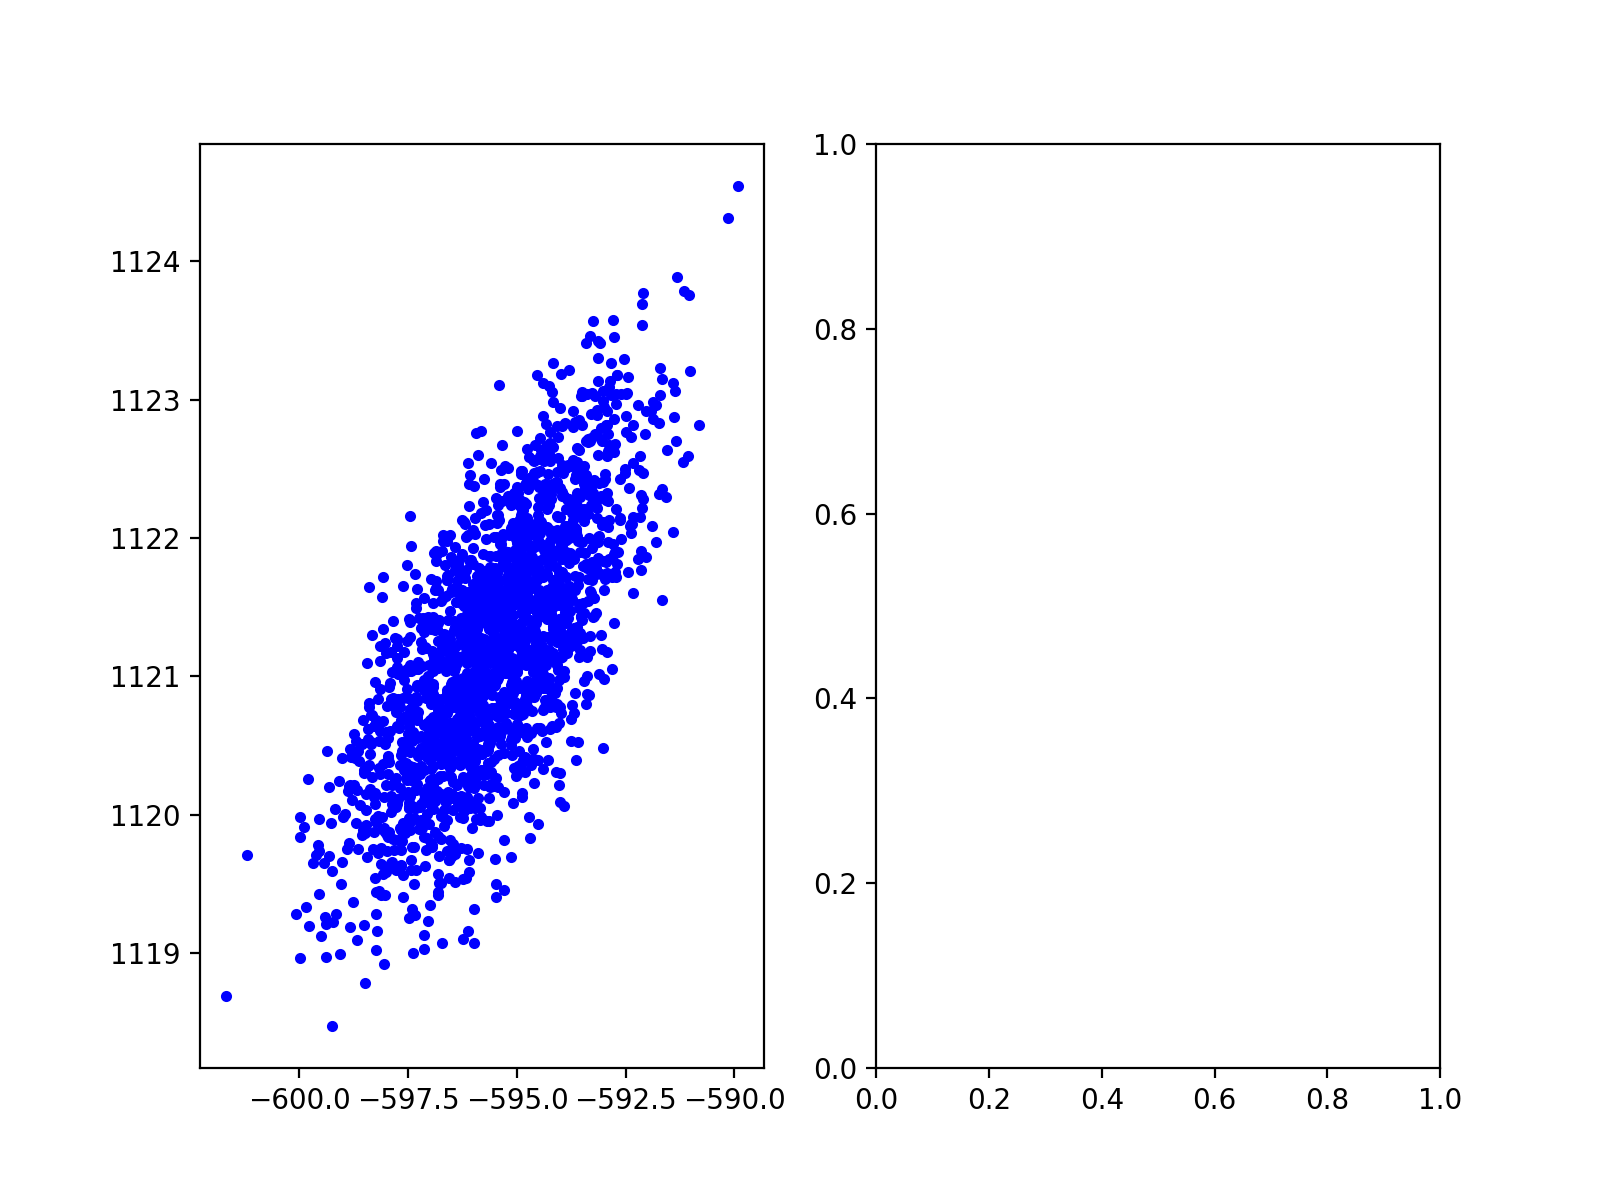

<IPython.core.display.Javascript object>


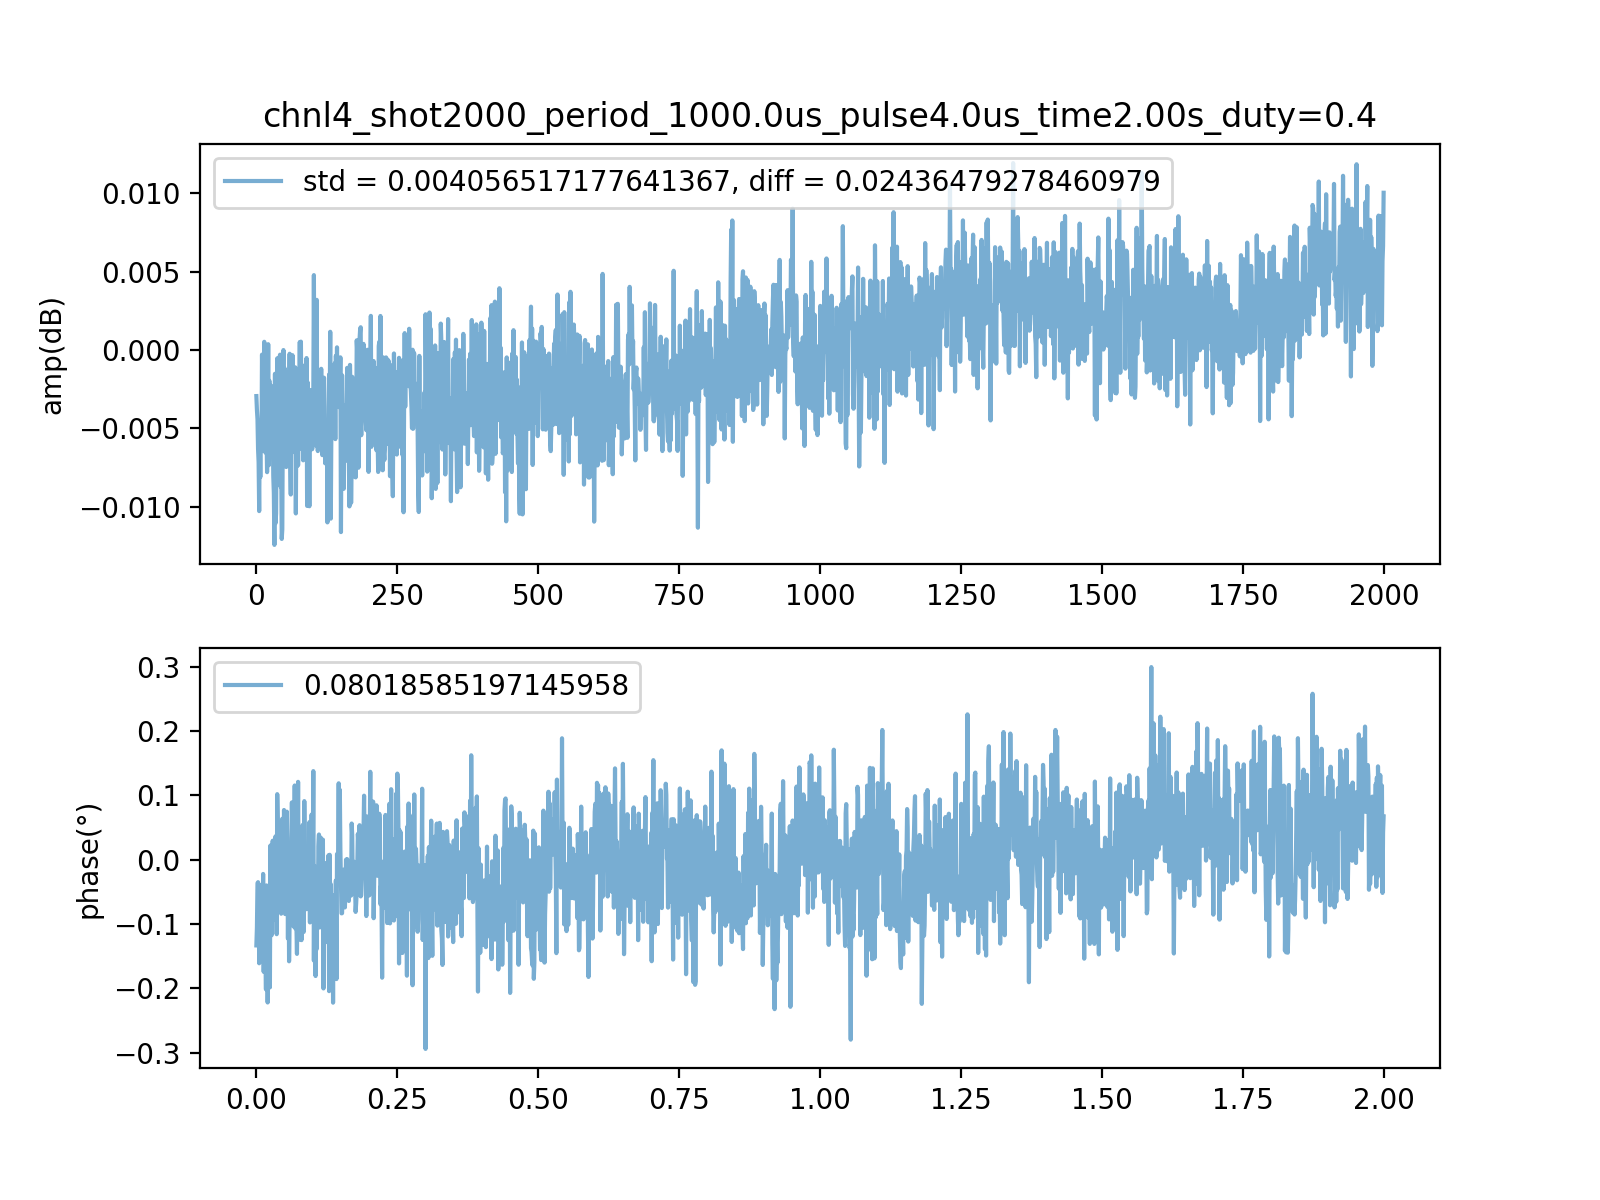

'\nplt.figure(figsize=(8,6))\nplt.subplot(211)\nplt.plot(20*np.log10(np.abs(tmp2)).T)\nplt.show()\nplt.subplot(212)\nplt.plot(np.angle(tmp2,True).T)\nplt.show()\n'

In [350]:
plt.figure(figsize=(8,6))
plt.subplot(121)

#plt.plot(np.real(tmp[0]),np.imag(tmp[0]), '.', color = 'r')
plt.plot(np.real(tmp2[0]),np.imag(tmp2[0]), '.', color = 'b')

plt.show()
plt.subplot(122)

#plt.plot(np.real(tmp[1]),np.imag(tmp[1]), '.', color = 'r')
#plt.plot(np.real(tmp2[1]),np.imag(tmp2[1]), '.', color = 'b')
plt.show()

dabs = 20*np.log10(np.abs(tmp2))
dangle = np.angle(tmp2, True)         



#sl新增
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.title(f'chnl{chnl}_shot{shots}_period_{period/1e3}us_pulse{time_len*1e6}us_time{shots*period*1e-9:.2f}s_duty={100*(time_len*1e6)/(period/1e3):.1f}')
plt.ylabel('amp(dB)')
for i in range(len(dabs)):
    plt.plot(dabs[i] - np.mean(dabs[i]), alpha = 0.6, label=f'std = {np.std(dabs[i])}, diff = {np.max(dabs[i] - np.min(dabs[i]))}')
#plt.plot(dabs[1] - np.mean(dabs[1]), alpha = 0.4, color = 'r')
plt.legend()


plt.subplot(212)
plt.ylabel('phase(°)')

for i in range(len(dangle)):
    plt.plot(np.linspace(0,shots*period*1e-9, len(dangle[i])),dangle[i] - np.mean(dangle[i]),alpha = 0.6, label=f'{np.std(dangle[i])}')
#plt.plot(dangle[1] - np.mean(dangle[1]),alpha = 0.4, color = 'r')

plt.legend()


'''
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(20*np.log10(np.abs(tmp2)).T)
plt.show()
plt.subplot(212)
plt.plot(np.angle(tmp2,True).T)
plt.show()
'''


### 获取原始信号

In [346]:
tmp = driver.get('TraceIQ', channel=4)
np.save(f'chnl{chnl}_shot{shots}_period_{period/1e3}us_pulse{time_len*1e6}us_time{shots*period*1e-9:.2f}s_duty={100*(time_len*1e6)/(period/1e3):.1f}.npy',tmp)
tmp.shape


(2000, 16000)

<IPython.core.display.Javascript object>


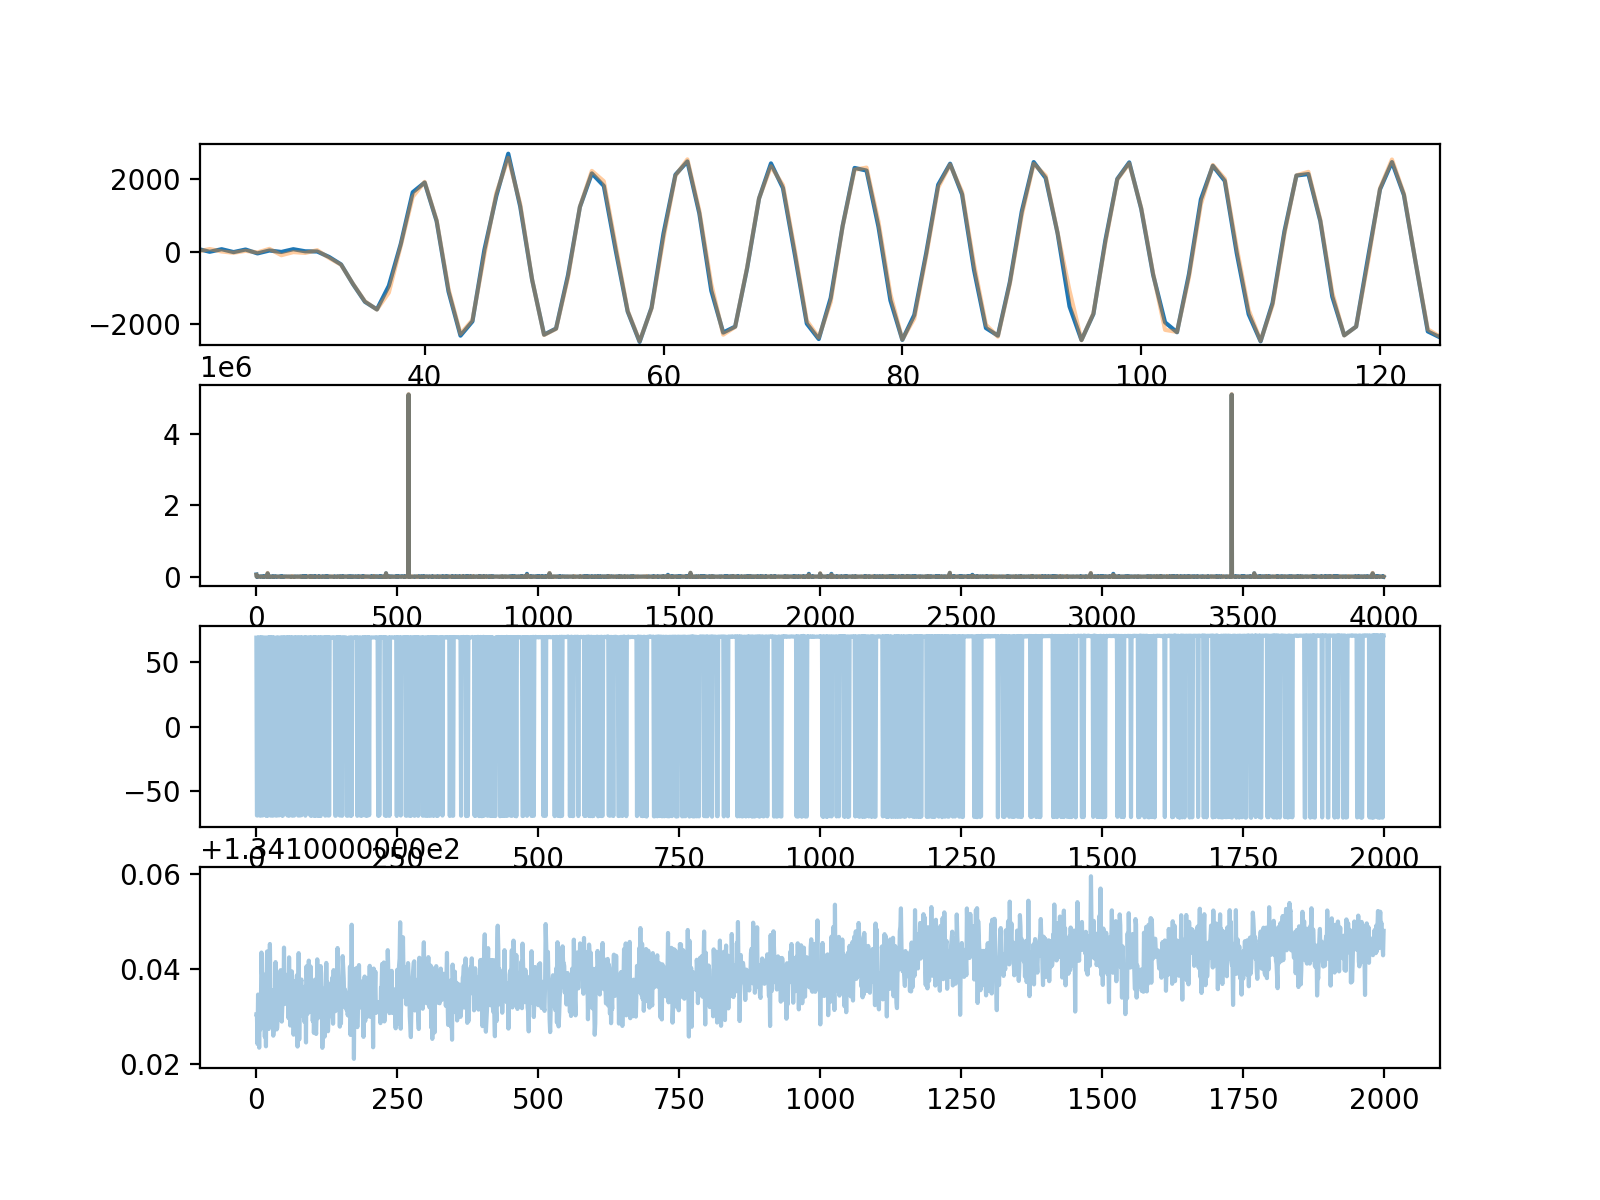

(2000, 4000)
(2000, 4000)


In [347]:
%matplotlib notebook


plt.figure(figsize=(8,6))
plt.subplot(411)
plt.plot(tmp[0,:])
plt.plot(tmp[1999,:], alpha =0.4)
plt.show()

tmp = tmp[:,1001:5001]
print(tmp.shape)

plt.subplot(412)
#fq = np.fft.fftfreq(int(len(tmp[0])),1/ADrate)
dfft = np.fft.fft(tmp)
print(dfft.shape)
plt.plot(np.abs(dfft[0]))
plt.plot(np.abs(np.fft.fft(tmp[1999])), alpha=0.4)

dangle = np.max(dfft,1)

plt.subplot(413)
#fq = np.fft.fftfreq(int(len(tmp[0])),1/ADrate)
#plt.plot(fq, np.angle(np.fft.fft(tmp[0]), True))
plt.plot(np.angle(dangle, True), alpha=0.4)


plt.subplot(414)
plt.plot(20*np.log10(np.abs(dangle)), alpha=0.4)


plt.show()



## 长时运行

In [20]:
DeviceIP = "192.168.1.195"

driver = Driver(DeviceIP)


sysparam = {
    'MixMode': 2, 'RefClock': 'in', 'DAC抽取倍数': 1, 'DAC本振频率':0 #, 'DArate': 4e9
}

driver.open(system_parameter=sysparam)

指令初始化执行成功
指令DAC配置执行成功
指令ADC配置执行成功


In [21]:
shots = 2000
driver.set('PointNumber', ADPointNumber)
driver.set('Shot', shots)

#for i in range(8):
driver.set('TriggerDelay', 750, 9)
        
driver.set('FrequencyList', freqlist,9)

driver.set('LinSpace', (0, (DAPointNumber-1)/DArate ,DAPointNumber),9)

driver.set('Waveform', wavs(tm), 9)    # 波形函数生成

PointNumber 配置成功
Shot 配置成功
TriggerDelay 配置成功
FrequencyList 配置成功
LinSpace 配置成功
Waveform 配置成功


In [25]:
start_time = TM.time()
runtime = 60   # 运行时长
rnd = 20       # 打印间隔
period = 200e3

cnt = 0
data = np.empty(shape=[0,8], dtype=complex)
data_rnd = np.zeros(8, dtype=complex)
current = TM.time() - start_time
while(current < runtime):
    for i in range(rnd):
        driver.set('StartCapture')  # 启动指令    
        driver.set('GenerateTrig',  period)
        
        for j in range(8):
            tmp2 = driver.get('IQ',channel=(j+1))  
            data_rnd[j] = np.mean(tmp2)
        data = np.append(data, [data_rnd], axis=0)
    current = TM.time() - start_time
    cnt += 1
    print(f'当前运行{current:.0f}s，{cnt}轮')
np.save('long_time_data.npy', data)


StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
当前运行31s，1轮
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功
GenerateTrig 配置成功
StartCapture 配置成功

In [26]:
data = np.swapaxes(data,0,1)
data.shape


(8, 40)

In [27]:
fig, axs = plt.subplots(8,2, figsize=(10,16))
for i in range(8):
    dabs = np.abs(data[i])
    axs[i][0].plot(dabs,label=f'std = {np.std(dabs[i])}, diff = {np.max(dabs[i] - np.min(dabs[i]))}')
    dangle = np.angle(data[i],True)
    axs[i][1].plot(dangle, label=f'std = {np.std(dangle[i])}, diff = {np.max(dangle[i] - np.min(dangle[i]))}')
fig.tight_layout()


<IPython.core.display.Javascript object>

## 硬解

In [167]:
HIQ = driver.get('IQ', value=1, channel=1)
HIQ.shape

(2, 1000, 12)

<IPython.core.display.Javascript object>


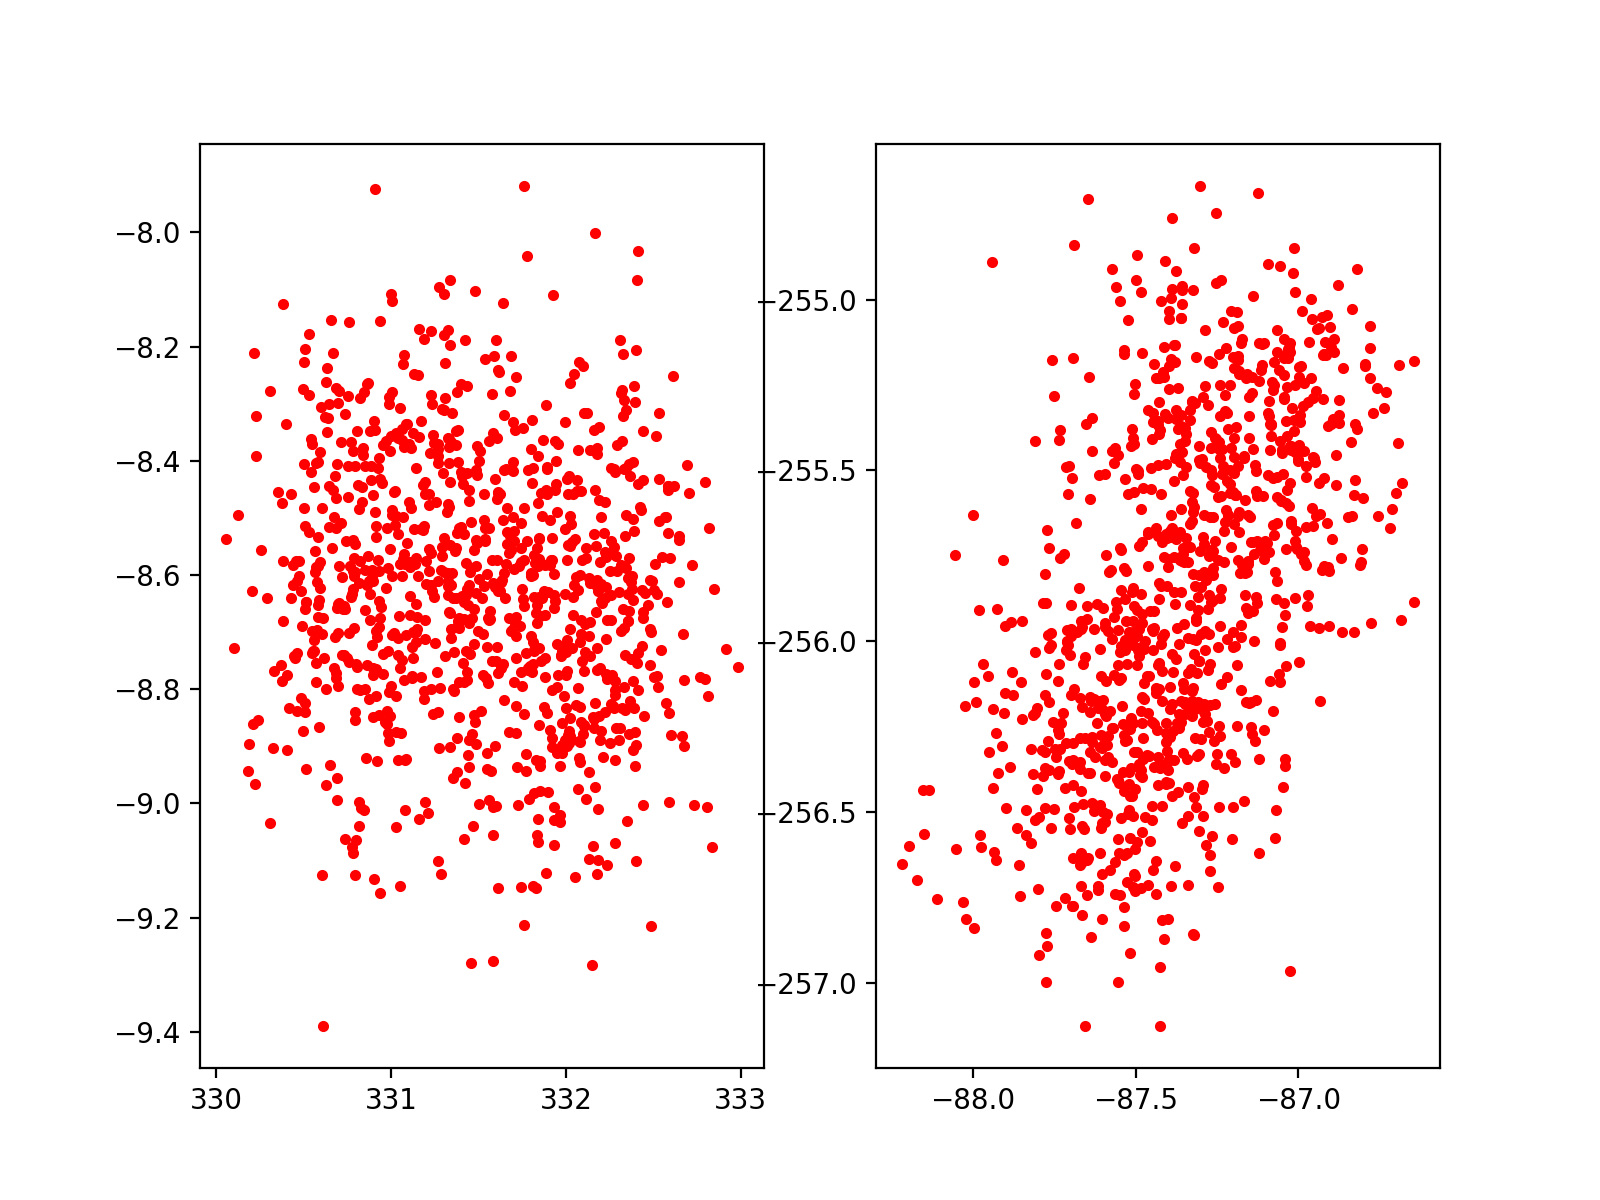

In [168]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.plot(HIQ[0,:,0], HIQ[1,:,0], '.', color = 'r')

plt.show()
plt.subplot(122)
plt.plot(HIQ[0,:,1], HIQ[1,:,1], '.', color = 'r')

plt.show()

# 设备复位

In [ ]:
# driver.set('Reset',0)

In [ ]:
# driver.close()